In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from models import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()

In [4]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.git'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.gitignore'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.vscode'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/README.md'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/__pycache__'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/dev_download_ucr.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/download.py'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/environment.yml'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/models'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/models.py'),
 PosixPath('/home/

In [5]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

In [6]:
num_classes = df_train.target.nunique(); num_classes

37

In [7]:
def process_dfs(df_train, df_test):
    x_train, y_train = df_train.values[:,:-1].astype('float'), df_train.values[:,-1].astype('int')
    x_test, y_test = df_test.values[:,:-1].astype('float'), df_test.values[:,-1].astype('int')

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()

    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)

    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(num_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(num_classes-1)
    return x_train, y_train, x_test, y_test

# DL

In [195]:
def to_TDS(x, y):
    return TensorDataset(torch.Tensor(x).unsqueeze(dim=1),  torch.Tensor(y).long())

def create_databunch(tr_ds, val_ds, bs=64):
    train_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
    return DataBunch(train_dl, valid_dl)

In [196]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [197]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [198]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [199]:
db = create_databunch(tr_ds, val_ds, 32)

Testing dims at input/output

In [200]:
tx, ty = next(iter(db.train_dl))

In [201]:
tx.shape, ty.shape

(torch.Size([32, 1, 176]), torch.Size([32]))

tensor([11,  9, 21, 34,  3,  9, 31, 27,  8, 30, 17, 36, 27, 34, 25,  8, 31, 20,
        18, 18,  9,  6, 19, 25,  1, 35, 35, 31, 15, 34, 33,  0],
       device='cuda:0')

## Resnet 1D

In [214]:
model = create_resnet(1, num_classes, conv_sizes=[64, 128, 256], stride=1)

In [215]:
# model = create_mlp(x_train[0].shape[0], num_classes)

In [216]:
# model = create_fcn(1, num_classes)

In [217]:
model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Sequent

In [213]:
model.cuda()(tx)[0].sigmoid().argmax()

tensor(24, device='cuda:0')

In [175]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


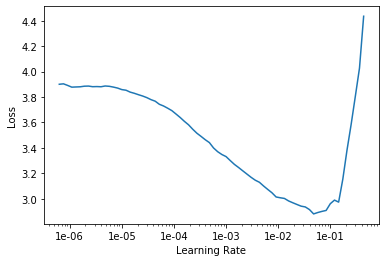

In [176]:
learn_res.lr_find(); learn_res.recorder.plot()

In [177]:
learn_res.fit_one_cycle(40, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.951614,4.530004,0.976982,00:00
1,2.598892,5.411458,0.976982,00:00
2,2.381330,3.941571,0.915601,00:00
3,2.238917,3.571826,0.928389,00:00
4,2.076605,9.319171,0.925831,00:00
5,1.957083,12.698791,0.941176,00:00
6,1.872968,16.170691,0.941176,00:00
7,1.760598,14.739734,0.941176,00:00
8,1.653667,12.415874,0.897698,00:00
9,1.603772,18.781393,0.910486,00:00


In [179]:
p, t = learn_res.get_preds()

In [180]:
error_rate(p,t)

tensor(0.2020)

In [181]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

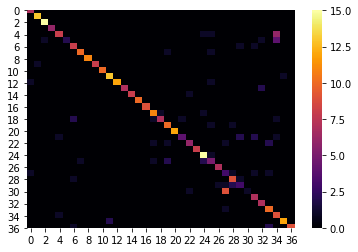

In [182]:
sns.heatmap(get_cm(p,t), cmap='inferno')